In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Inputs=pd.read_csv('Phi_T_sampling_uniform.csv')
Inputs

,Unnamed: 0,phi,T [K]
0,0,1.049164,1203.997776
1,1,0.943913,1102.764687
2,2,0.958025,1104.433889
3,3,0.945305,1139.583729
4,4,1.130658,1198.310346
...,...,...,...
95,95,1.032354,1165.841305
96,96,1.034471,1112.790878
97,97,1.082924,1118.270272
98,98,0.929695,1148.379224


In [7]:
Ts=Inputs.loc[:,'T [K]']
phis=Inputs.loc[:,'phi']

In [15]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [8]:
name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

model_name1='k_fold_best_model_PCA_test'

In [9]:
TAE_model_name='k_fold_best_model_test1'

In [12]:
TAE_all_scores=np.zeros((1,np.shape(Inputs)[0]))
print(np.shape(TAE_all_scores))


(1, 100)


In [27]:
n_ignition_cases=np.shape(Inputs)[0]

for j in range(n_ignition_cases):
    
    cantera_species=pd.read_csv(name_11+str(Ts[j])+name_12+str(phis[j])+end)
    cantera_species=pd.DataFrame(cantera_species)
    
    cantera_sources=pd.read_csv(name_21+str(Ts[j])+name_22+str(phis[j])+end)
    cantera_sources=pd.DataFrame(cantera_sources)
    
    maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
    maximum_values=pd.DataFrame(maximum_values)
    
    dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)
    
    Autoencoder = tf.keras.models.load_model(TAE_model_name, compile=False)
    results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()
    
    scores=np.zeros((1,1+n_columns_mass_fraction))
    
    model_outputs=pd.DataFrame(results, columns=columns[1:2+n_columns_mass_fraction])
    
    from sklearn.metrics import r2_score
    for k in range(1+n_columns_mass_fraction):
        scores[0,k]=r2_score(dataset.iloc[:,k+1],model_outputs.iloc[:,k])
    TAE_all_scores[0,j]=np.mean(scores[:])

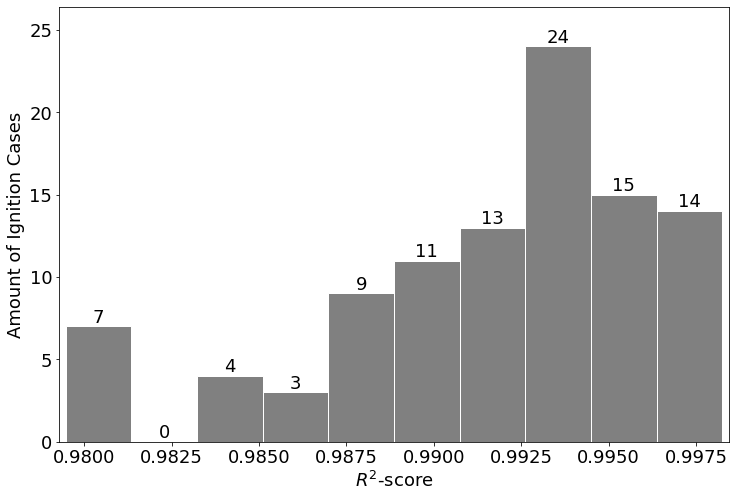

In [33]:
plt.figure(figsize=(12, 8))
values, bins, bars = plt.hist(np.transpose(TAE_all_scores), edgecolor='white',color='0.50')
plt.xlabel(r'$R^2$-score', fontsize = 18)
plt.ylabel(" of Ignition Cases", fontsize = 18)
plt.bar_label(bars, fontsize=18, color='k')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.margins(x=0.01, y=0.1)
plt.savefig('R2_scores_training_data.jpg', dpi=400)
plt.show()

mean_R2=np.mean(TAE_all_scores)
std_deviation_R2=np.std(TAE_all_scores)

In [31]:
print('mean',mean_R2)
print('std',std_deviation_R2)

mean 0.9916047424732362
std 0.004614575151111313
